In [25]:
from langchain_openai import OpenAIEmbeddings
from dotenv import load_dotenv
from langsmith import utils, traceable
import networkx as nx
import matplotlib.pyplot as plt

load_dotenv(dotenv_path='../.env')

utils.tracing_is_enabled()

embeddings = OpenAIEmbeddings(model="text-embedding-3-large")

In [26]:
from langchain_chroma.vectorstores import Chroma
from langchain_graph_retriever.transformers import ShreddingTransformer
from langchain_graph_retriever.adapters.chroma import ChromaAdapter

# load the vector store "./data/recipe_qa_combined_chroma_db"
# vector_store = Chroma(
#     embedding_function=embeddings,
#     collection_name="recipe_qa_combined",
#     persist_directory="./data/recipe_qa_combined_chroma_db"
# )
shredder = ShreddingTransformer() 
vector_store = ChromaAdapter(
    Chroma(
        embedding_function=embeddings,
        collection_name="recipe_qa_combined",
        persist_directory="./data/recipe_qa_combined_chroma_db",
    ),
    shredder,
    {"keywords"}
)

In [27]:
from graph_retriever.strategies import Eager
from langchain_graph_retriever import GraphRetriever

traversal_retriever = GraphRetriever(
    store = vector_store,
    edges = [("keywords", "keywords"), ("source_id", "source_id")],
    strategy = Eager(k=5, start_k=5, max_depth=3),
)

In [28]:
from langchain.chat_models import init_chat_model

llm = init_chat_model("gpt-4o-mini", model_provider="openai")

In [37]:
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables import RunnablePassthrough, RunnableLambda, RunnableParallel
from langchain_core.documents import Document

prompt = ChatPromptTemplate.from_template(
    """Answer the question based only on the context provided.

Context: {context}

Question: {question}"""
)

@traceable(run_type="chain")
def format_docs(docs:list[Document], config=None):
    print(docs)
    # formatted_docs = []
    # for doc in docs:
    #     doc_type = doc.metadata.get("type")
    #     f_doc = f"text: {doc.page_content} metadata: {doc.metadata}"
    #     if doc_type == "recipe":
    return {"context":"\n\n".join(
        f"text: {doc.page_content} metadata: {doc.metadata}" for doc in docs
    )}


# chain = (
#     {"sources": traversal_retriever}
#     | {"context": RunnableLambda(lambda x: format_docs(x['sources'])), "question": RunnablePassthrough()}
#     | prompt
#     | llm
#     | StrOutputParser()
# )

chain = (
    RunnableParallel(sources=traversal_retriever, question=RunnablePassthrough())
    | RunnableParallel(context=RunnableLambda(lambda x: format_docs(x['sources'])), question=RunnableLambda(lambda x: x['question']), sources=RunnableLambda(lambda x: x['sources']))
    | {"answer": prompt | llm, "sources": RunnableLambda(lambda x: x['sources'])}
    # | StrOutputParser()
)

In [38]:
response = chain.invoke("I'm in Ohio and I just had a small round chocolate that had peanut butter. I can't remeber the name of it. All I remember is that it had an 'eye' in the name. If you find it, get me the recipe")

[Document(id='2437_buckeyes', metadata={'keywords': ['Rice Krispies', 'butter', 'chocolate chips', 'crunchy peanut butter', 'paraffin', 'powdered sugar'], 'source_id': '2437_buckeyes', 'type': 'recipe'}, page_content='# Buckeyes\n\n## Ingredients\n- 1 stick butter, softened\n- 1 lb. powdered sugar\n- 2 c. crunchy peanut butter\n- 3 c. Rice Krispies\n- 12 oz. chocolate chips\n- 1/3 stick paraffin wax\n\n## Directions\n- Mix butter, sugar, peanut butter and Rice Krispies well.\n- Form mixture in balls about the size of a walnut.\n- Melt chocolate chips and paraffin in double boiler.\n- Dip balls in this mixture and place on wax paper until chocolate is set.\n'), Document(id='11_buckeyecandy', metadata={'keywords': ['butter', 'chocolate chips', 'paraffin', 'peanut butter', 'powdered sugar'], 'source_id': '11_buckeyecandy', 'type': 'recipe'}, page_content='# Buckeye Candy\n\n## Ingredients\n- 1 box powdered sugar\n- 8 oz. soft butter\n- 1 (8 oz.) peanut butter\n- paraffin\n- 12 oz. chocola

In [39]:
response['sources']

[Document(id='2437_buckeyes', metadata={'keywords': ['Rice Krispies', 'butter', 'chocolate chips', 'crunchy peanut butter', 'paraffin', 'powdered sugar'], 'source_id': '2437_buckeyes', 'type': 'recipe'}, page_content='# Buckeyes\n\n## Ingredients\n- 1 stick butter, softened\n- 1 lb. powdered sugar\n- 2 c. crunchy peanut butter\n- 3 c. Rice Krispies\n- 12 oz. chocolate chips\n- 1/3 stick paraffin wax\n\n## Directions\n- Mix butter, sugar, peanut butter and Rice Krispies well.\n- Form mixture in balls about the size of a walnut.\n- Melt chocolate chips and paraffin in double boiler.\n- Dip balls in this mixture and place on wax paper until chocolate is set.\n'),
 Document(id='11_buckeyecandy', metadata={'keywords': ['butter', 'chocolate chips', 'paraffin', 'peanut butter', 'powdered sugar'], 'source_id': '11_buckeyecandy', 'type': 'recipe'}, page_content='# Buckeye Candy\n\n## Ingredients\n- 1 box powdered sugar\n- 8 oz. soft butter\n- 1 (8 oz.) peanut butter\n- paraffin\n- 12 oz. chocol

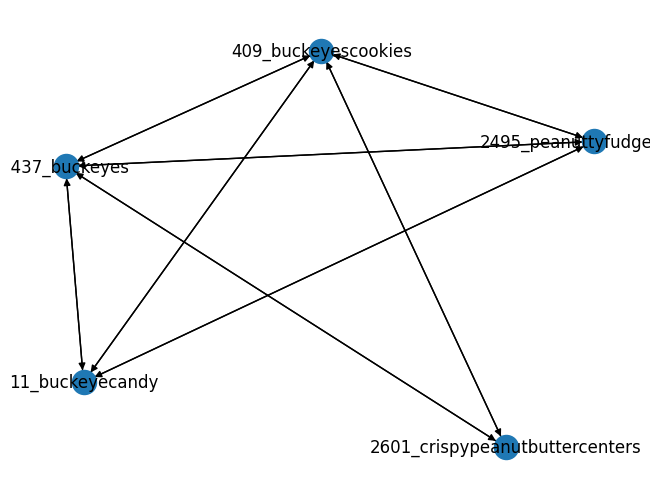

In [42]:
from langchain_graph_retriever.document_graph import create_graph

graph = create_graph(response['sources'], edges=[("keywords", "keywords"), ("source_id", "source_id")])
nx.draw(graph, with_labels=True)
plt.show()

In [ ]:
print(response.content)

The treat you're referring to is likely "Buckeyes." Here are the details for the recipe:

### Buckeyes Recipe

#### Ingredients
- 1 stick butter, softened
- 1 lb. powdered sugar
- 2 c. crunchy peanut butter
- 3 c. Rice Krispies
- 12 oz. chocolate chips
- 1/3 stick paraffin wax

#### Directions
1. Mix butter, sugar, peanut butter, and Rice Krispies well.
2. Form mixture into balls about the size of a walnut.
3. Melt chocolate chips and paraffin in a double boiler.
4. Dip the balls in this chocolate mixture and place on wax paper until the chocolate is set. 

Enjoy making your Buckeyes!
